# Task 4: Training Variational Autoencoders

### 1: Train the VAE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Device and hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
latent_dim = 20
epochs = 50
lr = 1e-3

# Transforms
transform = transforms.Compose([transforms.ToTensor()])

# Download datasets
train_dataset_full = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train/val (80/20)
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 48000, Val size: 12000, Test size: 10000


In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))  # Output in [0,1]

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div, recon_loss, kl_div

Epoch 1/50: Train Loss: 41.7580 (Recon: 34.7648, KL: 6.9932), Val Loss: 32.8202 (Recon: 24.5581, KL: 8.2620)
Epoch 2/50: Train Loss: 30.6119 (Recon: 22.5815, KL: 8.0304), Val Loss: 29.1325 (Recon: 21.2532, KL: 7.8794)
Epoch 3/50: Train Loss: 28.2503 (Recon: 20.2886, KL: 7.9617), Val Loss: 27.9128 (Recon: 19.5494, KL: 8.3634)
Epoch 4/50: Train Loss: 27.2295 (Recon: 19.2090, KL: 8.0206), Val Loss: 27.1341 (Recon: 19.0752, KL: 8.0589)
Epoch 5/50: Train Loss: 26.6694 (Recon: 18.6044, KL: 8.0651), Val Loss: 26.6882 (Recon: 18.4881, KL: 8.2001)
Epoch 6/50: Train Loss: 26.3498 (Recon: 18.2074, KL: 8.1424), Val Loss: 26.4344 (Recon: 18.5011, KL: 7.9332)
Epoch 7/50: Train Loss: 26.0452 (Recon: 17.8719, KL: 8.1732), Val Loss: 26.2366 (Recon: 17.7618, KL: 8.4749)
Epoch 8/50: Train Loss: 25.8398 (Recon: 17.6496, KL: 8.1902), Val Loss: 25.8248 (Recon: 17.6386, KL: 8.1862)
Epoch 9/50: Train Loss: 25.6345 (Recon: 17.4325, KL: 8.2019), Val Loss: 25.6528 (Recon: 17.5952, KL: 8.0576)
Epoch 10/50: Train 

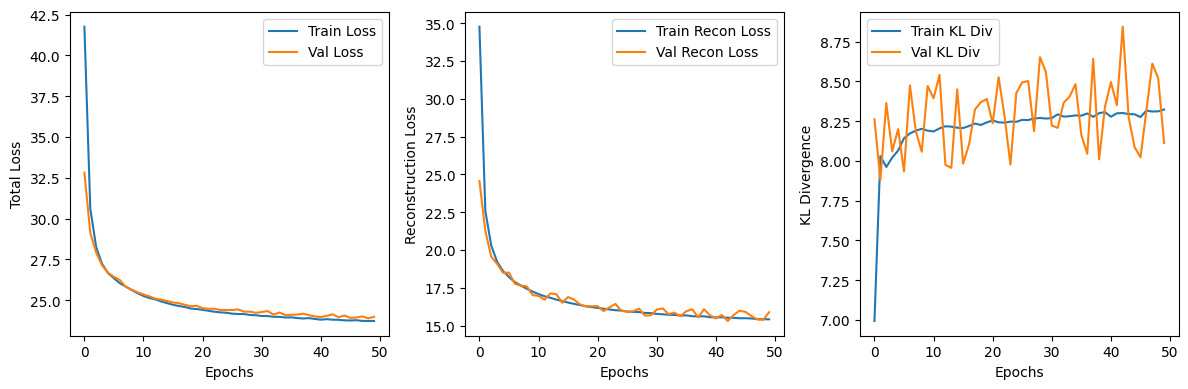

In [ ]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
train_recon_losses = []
train_kl_losses = []
val_losses = []
val_recon_losses = []
val_kl_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_recon = 0
    train_kl = 0
    for batch in train_loader:
        x, _ = batch
        x = x.to(device)
        recon_x, mu, logvar = model(x)
        loss, recon_loss, kl_div = vae_loss(recon_x, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_recon += recon_loss.item()
        train_kl += kl_div.item()
    train_loss /= len(train_loader.dataset)
    train_recon /= len(train_loader.dataset)
    train_kl /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_recon_losses.append(train_recon)
    train_kl_losses.append(train_kl)

    model.eval()
    val_loss = 0
    val_recon = 0
    val_kl = 0
    with torch.no_grad():
        for batch in val_loader:
            x, _ = batch
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss, recon_loss, kl_div = vae_loss(recon_x, x, mu, logvar)
            val_loss += loss.item()
            val_recon += recon_loss.item()
            val_kl += kl_div.item()
    val_loss /= len(val_loader.dataset)
    val_recon /= len(val_loader.dataset)
    val_kl /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_recon_losses.append(val_recon)
    val_kl_losses.append(val_kl)

    print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f}), '
          f'Val Loss: {val_loss:.4f} (Recon: {val_recon:.4f}, KL: {val_kl:.4f})')

# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(train_recon_losses, label='Train Recon Loss')
plt.plot(val_recon_losses, label='Val Recon Loss')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(train_kl_losses, label='Train KL Div')
plt.plot(val_kl_losses, label='Val KL Div')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.legend()
plt.tight_layout()
plt.show()

### 2: Visualize Reconstructions and Generations

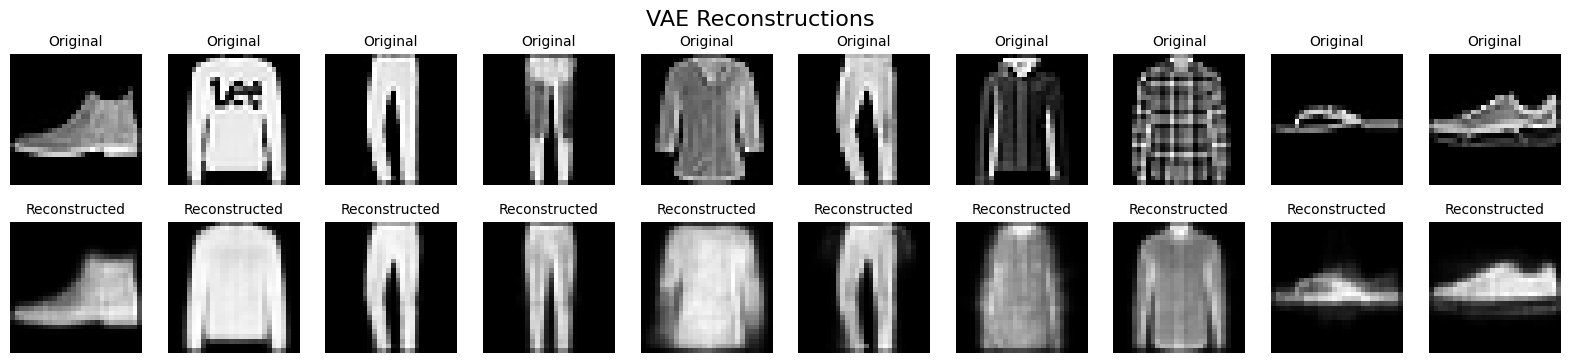

In [ ]:
def visualize_reconstructions(model, loader, n=10, title=""):
    model.eval()
    with torch.no_grad():
        batch = next(iter(loader))[0][:n].to(device)
        recon, _, _ = model(batch)
        recon = recon.view(-1, 1, 28, 28).cpu()
        original = batch.cpu()

        fig, axs = plt.subplots(2, n, figsize=(n*2, 4))
        if title:
            fig.suptitle(title, fontsize=16)
        for i in range(n):
            axs[0, i].imshow(original[i].squeeze(), cmap='gray')
            axs[0, i].set_title("Original", fontsize=10)
            axs[1, i].imshow(recon[i].squeeze(), cmap='gray')
            axs[1, i].set_title("Reconstructed", fontsize=10)
            axs[0, i].axis('off')
            axs[1, i].axis('off')
        plt.show()

visualize_reconstructions(model, test_loader, n=10, title="VAE Reconstructions")

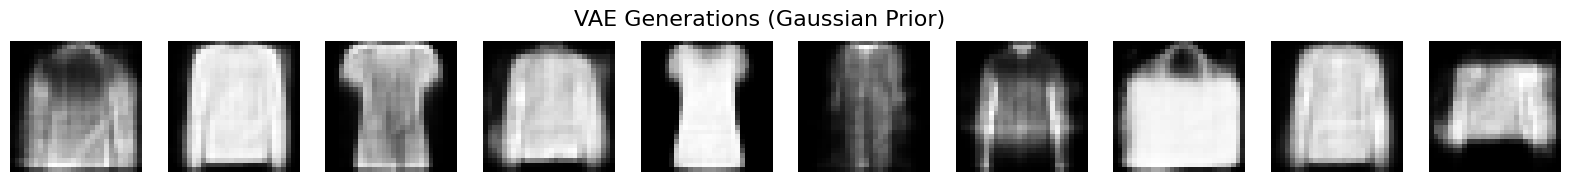

In [ ]:
def visualize_generations(model, n=10, title=""):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, latent_dim).to(device)
        samples = model.decode(z).view(-1, 1, 28, 28).cpu()

        fig, axs = plt.subplots(1, n, figsize=(n*2, 2))
        if title:
            fig.suptitle(title, fontsize=16)
        for i in range(n):
            axs[i].imshow(samples[i].squeeze(), cmap='gray')
            axs[i].axis('off')
        plt.show()

visualize_generations(model, n=10, title="VAE Generations (Gaussian Prior)")

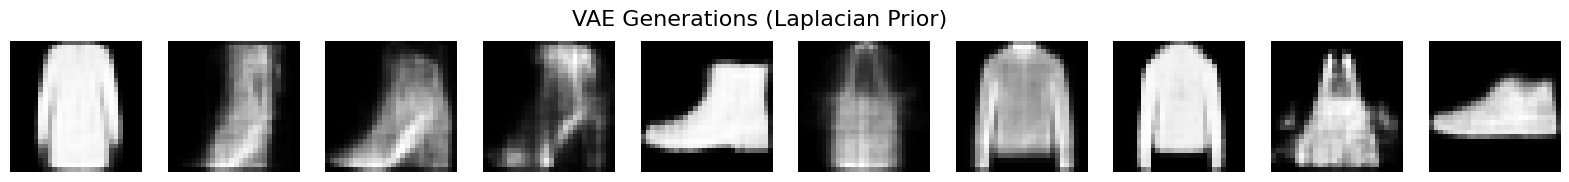

In [ ]:
def sample_laplacian(n, dim):
    u = torch.rand(n, dim) - 0.5
    return -torch.sign(u) * torch.log(1 - 2 * torch.abs(u))  # Scale=1

def visualize_laplacian_generations(model, n=10, title=""):
    model.eval()
    with torch.no_grad():
        z = sample_laplacian(n, latent_dim).to(device)
        samples = model.decode(z).view(-1, 1, 28, 28).cpu()

        fig, axs = plt.subplots(1, n, figsize=(n*2, 2))
        if title:
            fig.suptitle(title, fontsize=16)
        for i in range(n):
            axs[i].imshow(samples[i].squeeze(), cmap='gray')
            axs[i].axis('off')
        plt.show()

visualize_laplacian_generations(model, n=10, title="VAE Generations (Laplacian Prior)")

### 3: Posterior Collapse Investigation

In [ ]:
def check_posterior(model, loader, model_name=""):
    model.eval()
    mus, logvars = [], []
    with torch.no_grad():
        for batch in loader:
            x, _ = batch
            x = x.to(device)
            mu, logvar = model.encode(x.view(-1, 784))
            mus.append(mu.cpu())
            logvars.append(logvar.cpu())
    mus = torch.cat(mus)
    logvars = torch.cat(logvars)
    print(f'{model_name} - Mu Mean: {mus.mean():.4f}, Mu Var: {mus.var():.4f}, Std Mean: {torch.exp(logvars).mean():.4f}')
    return mus.mean(), mus.var(), torch.exp(logvars).mean()

mu_mean, mu_var, std_mean = check_posterior(model, test_loader, "VAE")

VAE - Mu Mean: -0.0128, Mu Var: 0.2994, Std Mean: 0.7064


### 4: Mitigating Posterior Collapse

In [ ]:
def vae_loss_beta(recon_x, x, mu, logvar, beta):
    recon_loss = nn.functional.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div, recon_loss, kl_div

Epoch 1/50: Beta: 0.00, Train Loss: 25.1637 (Recon: 25.1637, KL: 130.4899), Val Loss: 14.6498 (Recon: 14.6498, KL: 200.2292)
Epoch 2/50: Beta: 0.10, Train Loss: 18.6276 (Recon: 14.8476, KL: 37.7995), Val Loss: 16.8834 (Recon: 13.5365, KL: 33.4687)
Epoch 3/50: Beta: 0.20, Train Loss: 18.8565 (Recon: 13.7851, KL: 25.3568), Val Loss: 18.2508 (Recon: 13.2353, KL: 25.0775)
Epoch 4/50: Beta: 0.30, Train Loss: 20.1066 (Recon: 13.8356, KL: 20.9034), Val Loss: 19.7830 (Recon: 13.8017, KL: 19.9376)
Epoch 5/50: Beta: 0.40, Train Loss: 21.3355 (Recon: 14.2262, KL: 17.7731), Val Loss: 21.1040 (Recon: 14.4365, KL: 16.6687)
Epoch 6/50: Beta: 0.50, Train Loss: 22.4183 (Recon: 14.7150, KL: 15.4066), Val Loss: 22.2232 (Recon: 14.4890, KL: 15.4684)
Epoch 7/50: Beta: 0.60, Train Loss: 23.4055 (Recon: 15.2731, KL: 13.5540), Val Loss: 23.3008 (Recon: 15.1067, KL: 13.6567)
Epoch 8/50: Beta: 0.70, Train Loss: 24.2766 (Recon: 15.8021, KL: 12.1065), Val Loss: 24.1705 (Recon: 15.9157, KL: 11.7925)
Epoch 9/50: Be

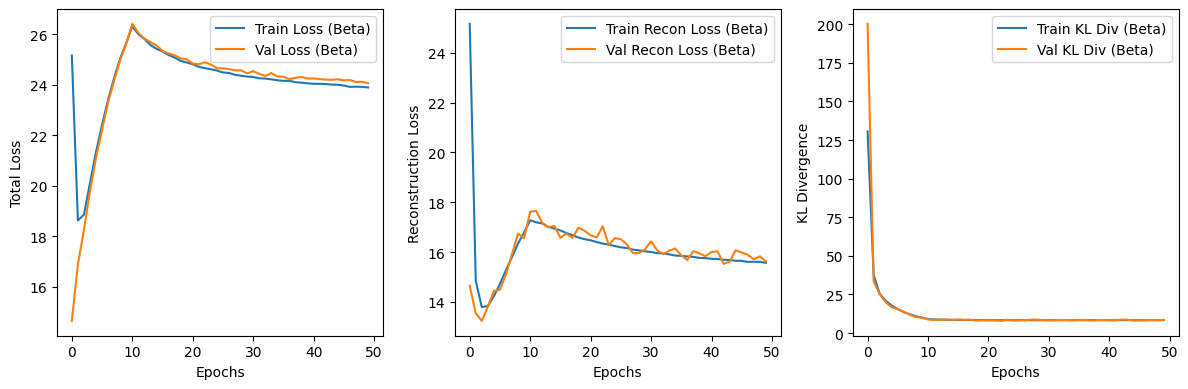

In [ ]:
model_beta = VAE().to(device)
optimizer_beta = optim.Adam(model_beta.parameters(), lr=lr)

train_losses_beta = []
train_recon_losses_beta = []
train_kl_losses_beta = []
val_losses_beta = []
val_recon_losses_beta = []
val_kl_losses_beta = []

warmup_epochs = 10  # Linear ramp over 10 epochs

for epoch in range(epochs):
    beta = min(1.0, epoch / warmup_epochs) if epoch < warmup_epochs else 1.0
    model_beta.train()
    train_loss = 0
    train_recon = 0
    train_kl = 0
    for batch in train_loader:
        x, _ = batch
        x = x.to(device)
        recon_x, mu, logvar = model_beta(x)
        loss, recon_loss, kl_div = vae_loss_beta(recon_x, x, mu, logvar, beta)
        optimizer_beta.zero_grad()
        loss.backward()
        optimizer_beta.step()
        train_loss += loss.item()
        train_recon += recon_loss.item()
        train_kl += kl_div.item()
    train_loss /= len(train_loader.dataset)
    train_recon /= len(train_loader.dataset)
    train_kl /= len(train_loader.dataset)
    train_losses_beta.append(train_loss)
    train_recon_losses_beta.append(train_recon)
    train_kl_losses_beta.append(train_kl)

    model_beta.eval()
    val_loss = 0
    val_recon = 0
    val_kl = 0
    with torch.no_grad():
        for batch in val_loader:
            x, _ = batch
            x = x.to(device)
            recon_x, mu, logvar = model_beta(x)
            loss, recon_loss, kl_div = vae_loss_beta(recon_x, x, mu, logvar, beta)
            val_loss += loss.item()
            val_recon += recon_loss.item()
            val_kl += kl_div.item()
    val_loss /= len(val_loader.dataset)
    val_recon /= len(val_loader.dataset)
    val_kl /= len(val_loader.dataset)
    val_losses_beta.append(val_loss)
    val_recon_losses_beta.append(val_recon)
    val_kl_losses_beta.append(val_kl)

    print(f'Epoch {epoch+1}/{epochs}: Beta: {beta:.2f}, Train Loss: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f}), '
          f'Val Loss: {val_loss:.4f} (Recon: {val_recon:.4f}, KL: {val_kl:.4f})')

# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses_beta, label='Train Loss (Beta)')
plt.plot(val_losses_beta, label='Val Loss (Beta)')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(train_recon_losses_beta, label='Train Recon Loss (Beta)')
plt.plot(val_recon_losses_beta, label='Val Recon Loss (Beta)')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(train_kl_losses_beta, label='Train KL Div (Beta)')
plt.plot(val_kl_losses_beta, label='Val KL Div (Beta)')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.legend()
plt.tight_layout()
plt.show()

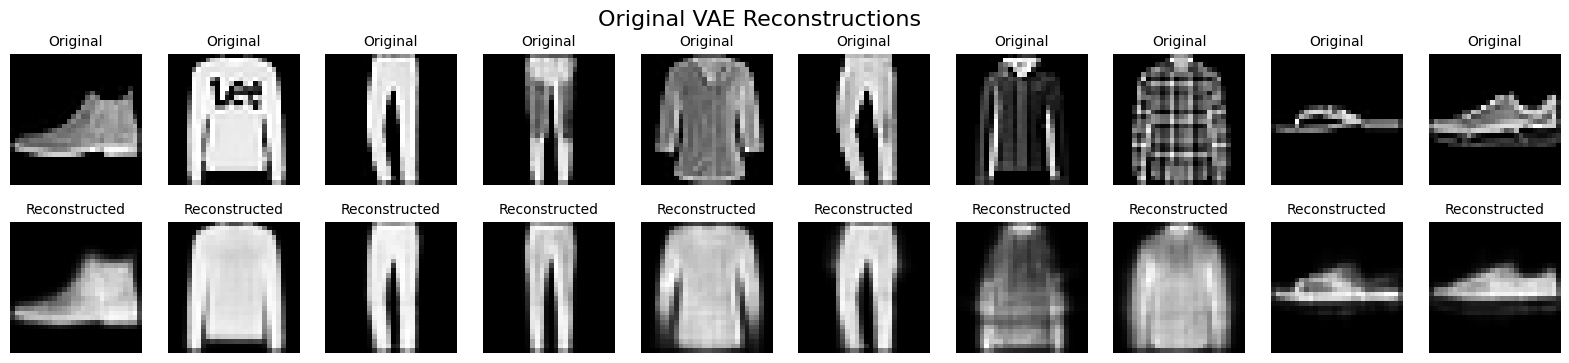

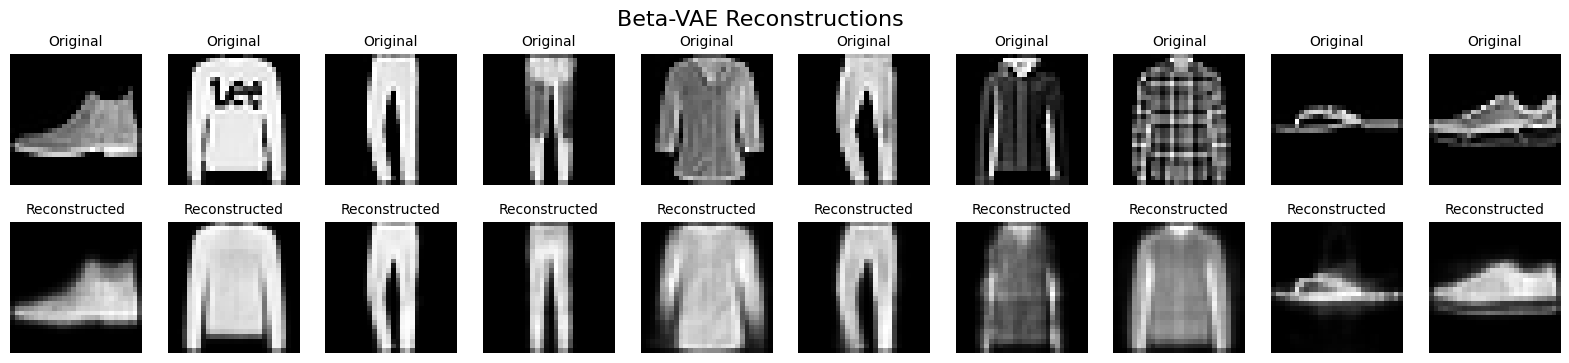

In [ ]:
# Reconstructions
visualize_reconstructions(model, test_loader, n=10, title="Original VAE Reconstructions")
visualize_reconstructions(model_beta, test_loader, n=10, title="Beta-VAE Reconstructions")

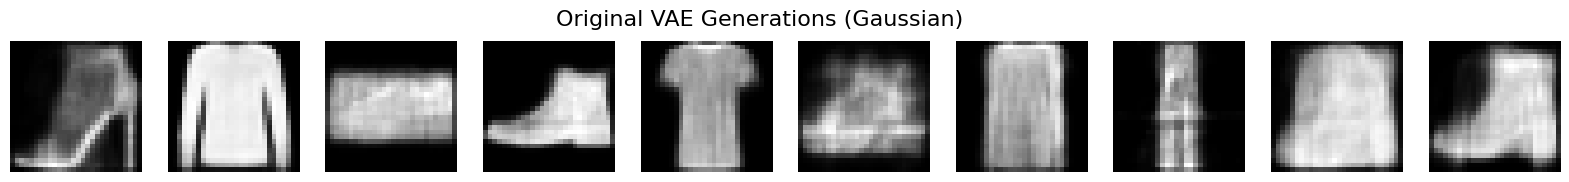

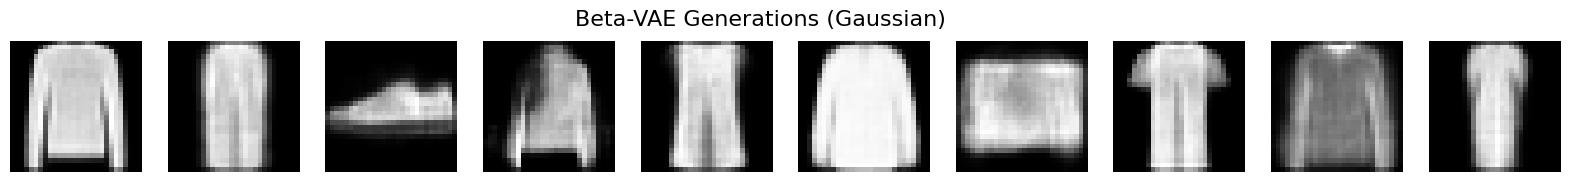

In [ ]:
# Generations (Gaussian)
visualize_generations(model, n=10, title="Original VAE Generations (Gaussian)")
visualize_generations(model_beta, n=10, title="Beta-VAE Generations (Gaussian)")

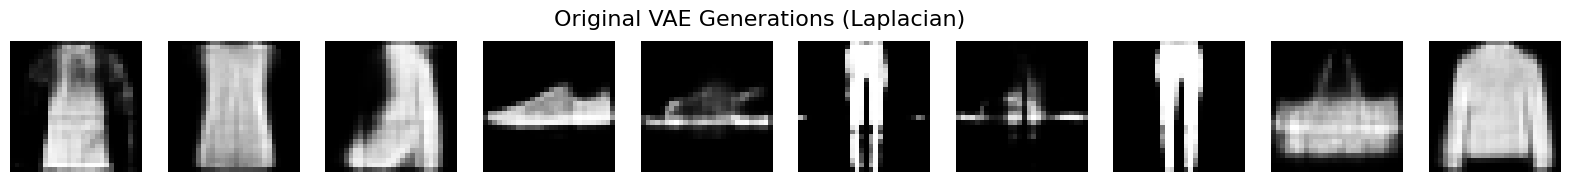

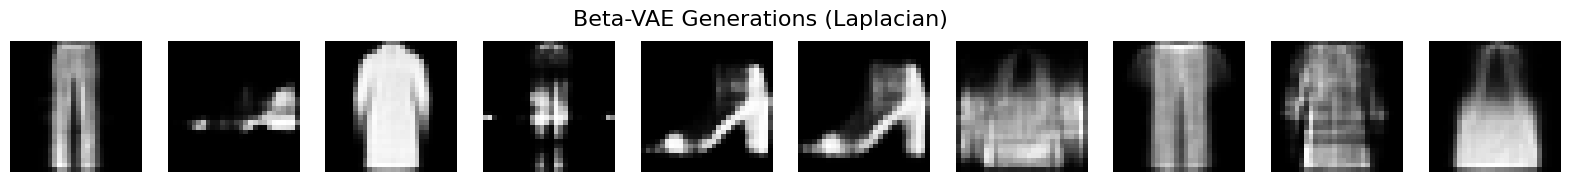

In [ ]:
# Generations (Laplacian)
visualize_laplacian_generations(model, n=10, title="Original VAE Generations (Laplacian)")
visualize_laplacian_generations(model_beta, n=10, title="Beta-VAE Generations (Laplacian)")

In [ ]:
def evaluate_elbo_components(model, loader, beta=1.0):
    model.eval()
    recon_total = 0
    kl_total = 0
    n_samples = 0
    with torch.no_grad():
        for batch in loader:
            x, _ = batch
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            _, recon_loss, kl_div = vae_loss_beta(recon_x, x, mu, logvar, beta)
            recon_total += recon_loss.item()
            kl_total += kl_div.item()
            n_samples += x.size(0)
    return recon_total / n_samples, kl_total / n_samples

# ELBO on test set
recon_orig, kl_orig = evaluate_elbo_components(model, test_loader)
recon_beta, kl_beta = evaluate_elbo_components(model_beta, test_loader)
print(f"Original VAE - Test Recon: {recon_orig:.4f}, KL: {kl_orig:.4f}")
print(f"Beta-VAE - Test Recon: {recon_beta:.4f}, KL: {kl_beta:.4f}")

# Posterior check
mu_mean_orig, mu_var_orig, std_mean_orig = check_posterior(model, test_loader, "Original VAE")
mu_mean_beta, mu_var_beta, std_mean_beta = check_posterior(model_beta, test_loader, "Beta-VAE")

Original VAE - Test Recon: 15.8699, KL: 8.0570
Beta-VAE - Test Recon: 15.5759, KL: 8.3781
Original VAE - Mu Mean: -0.0128, Mu Var: 0.2994, Std Mean: 0.7064
Beta-VAE - Mu Mean: -0.0015, Mu Var: 0.3105, Std Mean: 0.6881
